## This notebook will construct the nodes and edges that we will build our graph with

In this graph, we have two types of nodes, Spectra nodes and PeakRange nodes. A spectra node represents a spectra sample and a PeakRange represents a range of WaveNumber values, where a peak in this range has some presumed chemical or biological meaning based on(Masters Thesis). If a Spectra has a peak in a defined peak range, a relationship will exsist between those two nodes. The weight of the relationship will be the absorbance value of that peak.

Note that the Spectra used here is baseline corrected, scaled and only uses WaveNumbers between 400 and 1800.

Import relevant libraries and import raw data

In [4]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [6]:
#df = pd.read_csv("../../data/current_clean_spectrum.csv")
df = pd.read_csv("../../data/kfold_parameters.csv")

In [7]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)].reset_index()

In [ ]:
# def normalise(absorbances):
#     max_value = np.max(absorbances)
#     normalized_absorbances = absorbances / max_value
#     return normalized_absorbances

# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [ ]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [19]:
# peaks = []
# widths = []
# prom = []

# for _, group in df.groupby('SpecID'):
#     peak_index, weights = find_peaks(x=group['Absorbance'], distance=152, prominence=0.01, width=6)
#     peaks += list(group.iloc[peak_index].index.values)
#     widths += list(weights['widths'])
#     prom += list(weights['prominences'])

peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], distance=152, prominence=0.00005, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [20]:
print(len(peaks))

25426


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

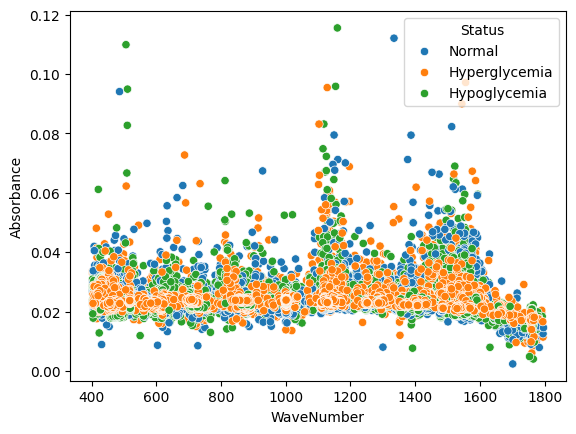

In [21]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [22]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_33373/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_33373/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [23]:
peak_df

,index,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences
190,190,201210-1-00,483,530.06836,201210-1,Normal,0.024000,11.353188,0.000113
431,431,201210-1-00,724,694.76080,201210-1,Normal,0.025636,40.603053,0.002124
731,731,201210-1-00,1024,899.77222,201210-1,Normal,0.024130,110.869465,0.001405
883,883,201210-1-00,1176,1003.64470,201210-1,Normal,0.023691,38.784962,0.001060
1075,1075,201210-1-00,1368,1134.85190,201210-1,Normal,0.022131,25.966827,0.000172
...,...,...,...,...,...,...,...,...,...
6227790,6227790,210526-3-49,1172,1000.91110,210526-3,Hyperglycemia,0.023861,33.681589,0.001028
6227976,6227976,210526-3-49,1358,1128.01820,210526-3,Hyperglycemia,0.023011,61.944315,0.000503
6228157,6228157,210526-3-49,1539,1251.70840,210526-3,Hyperglycemia,0.022929,47.680959,0.000599
6228344,6228344,210526-3-49,1726,1379.49890,210526-3,Hyperglycemia,0.022228,31.528103,0.000289


In [24]:
peaks = [[407, 495], [453,454], [516,537], 519, [603,738], [620, 624], [821, 839], [866, 887], 972, [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], 1170, [1188, 1196], [1212-1294], [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], 1668]

In [25]:
# Peaks list, corrected format
peaks_corrected = [[407, 495], [453, 454], [516, 537], [519, 519], [603, 738], [620, 624], [821, 839], [866, 887], [972, 972], 
         [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], [1170, 1170], [1188, 1196], [1212, 1294], 
         [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], [1668, 1668]]

# Convert peaks to a more efficient structure for processing
peak_ranges = [(peak[0], peak[1]) for peak in peaks_corrected]

# Create a function to determine the peak range for each WaveNumber
def find_peak_range(wavenumber):
    for start, end in peak_ranges:
        if start <= wavenumber <= end:
            return f"{start}-{end}"
    return None

# Apply the function to create a new column for peak range
peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)

# Now, group by both SpecID and the new PeakRange column, and compute max Absorbance for each group
grouped = peak_df.groupby(['SpecID', 'PeakRange'])['Absorbance'].max().reset_index()

# Pivot the table to have SpecID as rows and PeakRange as columns, filled with max Absorbance values
efficient_pivot_df = grouped.pivot(index='SpecID', columns='PeakRange', values='Absorbance').reset_index()

# Fill NaN values with an appropriate placeholder if needed (e.g., 0 or empty string), here we keep NaNs
efficient_pivot_df


/tmp/ipykernel_33373/3083927011.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)


PeakRange,SpecID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,1611-1653,407-495,516-537,603-738,821-839,866-887
0,201210-1-00,NaN,NaN,NaN,0.022131,NaN,0.021797,0.021219,NaN,NaN,0.020383,NaN,NaN,0.024000,0.025636,NaN,NaN
1,201210-1-01,NaN,NaN,NaN,0.021943,NaN,0.021581,0.021608,NaN,NaN,NaN,0.021385,0.024953,NaN,0.025339,NaN,NaN
2,201210-1-02,NaN,NaN,NaN,NaN,NaN,0.022166,0.022804,NaN,NaN,NaN,0.024280,0.022199,NaN,0.027279,NaN,NaN
3,201210-1-03,NaN,NaN,0.023398,NaN,NaN,0.024828,NaN,NaN,NaN,NaN,NaN,0.022027,NaN,0.027690,NaN,NaN
4,201210-1-04,NaN,NaN,NaN,NaN,NaN,NaN,0.023609,NaN,NaN,NaN,0.024497,0.022749,NaN,0.022670,NaN,0.021425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,0.023929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021023,NaN,NaN,NaN,0.023272,0.023736,NaN,NaN
3041,210526-3-46,0.023834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023318,0.023761,NaN,NaN
3042,210526-3-47,0.023938,NaN,NaN,NaN,NaN,0.022875,NaN,NaN,0.020993,NaN,NaN,NaN,0.023477,0.023777,NaN,0.023679
3043,210526-3-48,0.023697,NaN,NaN,NaN,NaN,0.022797,NaN,NaN,NaN,NaN,NaN,NaN,0.023512,0.023931,NaN,NaN


In [26]:
# Melt the DataFrame to transform it into a long format
long_format_df = efficient_pivot_df.melt(id_vars='SpecID', var_name='PeakRange', value_name='Weight')

# Drop NaN values
long_format_df.dropna(inplace=True)

long_format_df.reset_index(drop=True, inplace=True)
long_format_df

,SpecID,PeakRange,Weight
0,201210-1-05,1000-1003,0.021616
1,201210-1-09,1000-1003,0.022031
2,201210-1-14,1000-1003,0.022329
3,201210-1-18,1000-1003,0.021936
4,201210-1-20,1000-1003,0.021975
...,...,...,...
14142,210526-3-38,866-887,0.023713
14143,210526-3-39,866-887,0.023723
14144,210526-3-43,866-887,0.023773
14145,210526-3-44,866-887,0.023787


In [27]:
long_format_df.rename(columns={'SpecID':'SpecID:START_ID', 'PeakRange':'PeakRange:END_ID', 'Weight':'Weight:float'}, inplace=True)
long_format_df[':TYPE'] = 'Has_Peak'

In [28]:
long_format_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [29]:
spectra_df = long_format_df.groupby(['SpecID:START_ID']).first().reset_index()
spectra_df.drop(columns=['PeakRange:END_ID', 'Weight:float', ':TYPE'], inplace=True)

In [30]:
spectra_df.rename(columns={'SpecID:START_ID': 'SpecID:ID'}, inplace=True)
spectra_df[':LABEL'] = 'Spectra'

In [31]:
spectra_df

,SpecID:ID,:LABEL
0,201210-1-00,Spectra
1,201210-1-01,Spectra
2,201210-1-02,Spectra
3,201210-1-03,Spectra
4,201210-1-04,Spectra
...,...,...
3040,210526-3-45,Spectra
3041,210526-3-46,Spectra
3042,210526-3-47,Spectra
3043,210526-3-48,Spectra


In [32]:
spectra_df.to_csv(f"{neo4j_directory}/import/spectra.csv", index=False)

In [33]:
peak_range_df = long_format_df.groupby(['PeakRange:END_ID']).first().reset_index()
peak_range_df.drop(columns=['SpecID:START_ID', 'Weight:float', ':TYPE'], inplace=True)

In [34]:
peak_range_df.rename(columns={'PeakRange:END_ID':'PeakRange:ID'}, inplace=True)
peak_range_df[':LABEL'] = 'PeakRange'

In [35]:
peak_range_df.to_csv(f"{neo4j_directory}/import/peakrange.csv", index=False)

In [36]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [37]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/spectra.csv --nodes=import/peakrange.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/spectra.csv', '--nodes=import/peakrange.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/spectra.csv\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/peakrange.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 5.097GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 3.816GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stan

In [38]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ff

Run and connect to the Neo4j Database

In [39]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [40]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['PeakRange', 'Spectra'],
      {
        Has_Peak: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Unable to retrieve routing information
Transaction failed and will be retried in 0.9540942074178855s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 2.0534732209318185s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.359443265754902s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 7.666739915512819s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 15.477830866475593s (Unable to retrieve routing information)


Define the graph algorithms.

In [41]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [42]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [43]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [44]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, score
    ORDER BY score DESC, SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["score"]) for record in results]

In [45]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [46]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [47]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, Community
    ORDER BY Community, PeakRange, SpecID
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["Community"]) for record in results]

In [48]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [49]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS SpecID, gds.util.asNode(nodeId).PeakRange AS PeakRange, embedding
    ORDER BY SpecID ASC, PeakRange ASC
    """
    results = tx.run(query)
    return [(record["SpecID"], record["PeakRange"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [50]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [51]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['SpecID', 'PeakRange', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['SpecID', 'PeakRange', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['SpecID', 'PeakRange', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['SpecID', 'PeakRange', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['SpecID', 'PeakRange', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['SpecID', 'PeakRange', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['SpecID', 'PeakRange', 'Louvain'])

In [52]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['SpecID', 'PeakRange'], how='left')

In [53]:
df = merged_df
df

,SpecID,PeakRange,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,None,603-738,274.093117,69.523458,0.559114,1.105976,3,552
1,None,407-495,257.957864,66.168260,0.532131,1.059756,10,552
2,None,1212-1294,178.824972,45.926573,0.369345,0.781441,12,551
3,None,1542-1594,141.854725,37.490020,0.301498,0.665319,11,555
4,None,1000-1003,115.792620,30.467206,0.245020,0.568813,4,552
...,...,...,...,...,...,...,...,...
3056,210421-1-00,None,0.219774,0.021408,0.000176,0.150258,12,551
3057,210415-1-49,None,0.219706,0.021119,0.000173,0.150252,3,549
3058,210415-1-34,None,0.219381,0.021020,0.000173,0.150251,3,549
3059,210225-2-09,None,0.214408,0.019737,0.000162,0.150236,10,552


In [54]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'PeakRange', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,PeakRange,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,None,0.127561,0.109450,0.187401,-0.053689,0.096557,-0.128793,-0.060143,-0.088462,...,-0.135859,0.025974,-0.035301,-0.156204,0.034215,-0.143229,0.139070,-0.038293,-0.280110,-0.179616
1,201210-1-01,None,0.071049,0.100193,0.180587,-0.079900,0.063673,-0.108309,-0.096000,-0.097453,...,-0.136642,-0.037430,-0.026152,-0.161660,0.054384,-0.136817,0.067792,-0.063977,-0.277089,-0.230823
2,201210-1-02,None,0.043493,0.100990,0.179079,-0.044565,0.074796,-0.124202,-0.081039,-0.065694,...,-0.143320,-0.022678,-0.045618,-0.115972,0.014403,-0.130222,0.073117,-0.081445,-0.268615,-0.244056
3,201210-1-03,None,0.023975,0.045869,0.216673,-0.090494,0.101828,-0.121434,-0.138722,-0.006256,...,-0.109944,0.012325,-0.036118,-0.114419,0.060054,-0.176535,0.119971,-0.079000,-0.236983,-0.156821
4,201210-1-04,None,0.032367,0.156756,0.190761,0.016199,0.053975,-0.152259,-0.074781,-0.077293,...,-0.120576,-0.015455,-0.019112,-0.120383,-0.015571,-0.094987,0.056800,-0.070293,-0.247561,-0.256136


In [55]:
status_df = peak_df.groupby(['SpecID', 'SurID', 'Status']).first().reset_index()
status_df.drop(columns=['index', 'Seq', 'WaveNumber', 'Absorbance', 'Widths', 'Prominences', 'PeakRange'], inplace=True)

In [56]:
status_df

,SpecID,SurID,Status
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [57]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
graph_df.drop(columns=['PeakRange'], inplace=True)

In [58]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")
fast_graph_df.drop(columns=['PeakRange'], inplace=True)

In [59]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [60]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [61]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,SurID,Status
0,201210-1-00,0.127561,0.109450,0.187401,-0.053689,0.096557,-0.128793,-0.060143,-0.088462,0.191778,...,-0.035301,-0.156204,0.034215,-0.143229,0.139070,-0.038293,-0.280110,-0.179616,201210-1,Normal
1,201210-1-01,0.071049,0.100193,0.180587,-0.079900,0.063673,-0.108309,-0.096000,-0.097453,0.167989,...,-0.026152,-0.161660,0.054384,-0.136817,0.067792,-0.063977,-0.277089,-0.230823,201210-1,Normal
2,201210-1-02,0.043493,0.100990,0.179079,-0.044565,0.074796,-0.124202,-0.081039,-0.065694,0.168298,...,-0.045618,-0.115972,0.014403,-0.130222,0.073117,-0.081445,-0.268615,-0.244056,201210-1,Normal
3,201210-1-03,0.023975,0.045869,0.216673,-0.090494,0.101828,-0.121434,-0.138722,-0.006256,0.139701,...,-0.036118,-0.114419,0.060054,-0.176535,0.119971,-0.079000,-0.236983,-0.156821,201210-1,Normal
4,201210-1-04,0.032367,0.156756,0.190761,0.016199,0.053975,-0.152259,-0.074781,-0.077293,0.163407,...,-0.019112,-0.120383,-0.015571,-0.094987,0.056800,-0.070293,-0.247561,-0.256136,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,0.103662,0.068907,0.123357,-0.089165,0.108892,-0.092604,-0.011149,-0.042484,0.103720,...,-0.069627,-0.087398,0.023214,-0.203521,0.189326,-0.034470,-0.297697,-0.212888,210526-3,Hyperglycemia
3041,210526-3-46,0.083194,0.056539,0.095340,-0.002797,0.125064,-0.115317,-0.038237,-0.027608,0.139195,...,-0.049251,-0.105877,-0.013914,-0.158446,0.191701,-0.013047,-0.323821,-0.152660,210526-3,Hyperglycemia
3042,210526-3-47,0.095115,0.139014,0.138293,-0.079517,0.112102,-0.140426,-0.029490,-0.031326,0.126398,...,-0.052096,-0.091933,0.039840,-0.171083,0.207079,-0.037915,-0.277247,-0.180938,210526-3,Hyperglycemia
3043,210526-3-48,0.089299,0.068673,0.104734,-0.055886,0.132601,-0.124700,-0.049118,-0.019244,0.147486,...,-0.058427,-0.102071,0.020492,-0.166358,0.207076,-0.026603,-0.316710,-0.141461,210526-3,Hyperglycemia


In [62]:
graph_df.fillna(0, inplace=True)
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status
0,210311-1-09,0.958114,0.249540,0.002048,0.153051,10,552,210311-1,Normal
1,210318-1-24,0.903215,0.234438,0.001924,0.152870,4,552,210318-1,Hypoglycemia
2,210401-1-04,0.886875,0.229998,0.001887,0.152826,12,551,210401-1,Hypoglycemia
3,210120-1-20,0.881552,0.228971,0.001879,0.152792,11,555,210120-1,Hyperglycemia
4,210310-1-03,0.844455,0.214032,0.001756,0.152679,10,555,210310-1,Normal
...,...,...,...,...,...,...,...,...,...
3040,210421-1-00,0.219774,0.021408,0.000176,0.150258,12,551,210421-1,Normal
3041,210415-1-49,0.219706,0.021119,0.000173,0.150252,3,549,210415-1,Hypoglycemia
3042,210415-1-34,0.219381,0.021020,0.000173,0.150251,3,549,210415-1,Hypoglycemia
3043,210225-2-09,0.214408,0.019737,0.000162,0.150236,10,552,210225-2,Hypoglycemia


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import numpy as np

def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID', 'SpecID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [64]:
evaluate_extra_trees(graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3868 +/- 0.0431


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = graph_df.drop(['Status', 'SurID', 'SpecID'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.4864 +/- 0.0257
RandomForestClassifier Cross-Validation Precision: 0.4850 +/- 0.0277
RandomForestClassifier Cross-Validation Recall: 0.4864 +/- 0.0284
RandomForestClassifier Cross-Validation F1-Score: 0.4836 +/- 0.0281
ExtraTreesClassifier Cross-Validation Accuracy: 0.4815 +/- 0.0249
ExtraTreesClassifier Cross-Validation Precision: 0.4811 +/- 0.0243
ExtraTreesClassifier Cross-Validation Recall: 0.4819 +/- 0.0257
ExtraTreesClassifier Cross-Validation F1-Score: 0.4791 +/- 0.0246


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/py

SVC Cross-Validation Accuracy: 0.3222 +/- 0.0196
SVC Cross-Validation Precision: 0.1074 +/- 0.0065
SVC Cross-Validation Recall: 0.3333 +/- 0.0000
SVC Cross-Validation F1-Score: 0.1623 +/- 0.0075


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## FastRp

In [67]:
evaluate_extra_trees(fast_graph_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4585 +/- 0.0490


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = fast_graph_df.drop(['Status', 'SurID', 'SpecID'], axis=1)
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.5823 +/- 0.0218
RandomForestClassifier Cross-Validation Precision: 0.5806 +/- 0.0199
RandomForestClassifier Cross-Validation Recall: 0.5822 +/- 0.0202
RandomForestClassifier Cross-Validation F1-Score: 0.5799 +/- 0.0199
ExtraTreesClassifier Cross-Validation Accuracy: 0.5806 +/- 0.0220
ExtraTreesClassifier Cross-Validation Precision: 0.5802 +/- 0.0217
ExtraTreesClassifier Cross-Validation Recall: 0.5822 +/- 0.0211
ExtraTreesClassifier Cross-Validation F1-Score: 0.5789 +/- 0.0209
SVC Cross-Validation Accuracy: 0.4716 +/- 0.0343
SVC Cross-Validation Precision: 0.4841 +/- 0.0403
SVC Cross-Validation Recall: 0.4640 +/- 0.0323
SVC Cross-Validation F1-Score: 0.4568 +/- 0.0362


Fast rp mixed with traditional graph metrics

In [69]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status', 'SurID'], how='inner')

In [70]:
joined_graph

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,SurID,Status,embedding_0,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210311-1-09,0.958114,0.249540,0.002048,0.153051,10,552,210311-1,Normal,0.063442,...,-0.103370,0.014782,-0.010605,-0.164701,7.416941e-02,-0.150795,0.082454,-0.081622,-0.246926,-0.195272
1,210318-1-24,0.903215,0.234438,0.001924,0.152870,4,552,210318-1,Hypoglycemia,0.097863,...,-0.108359,0.063221,-0.030804,-0.123023,3.496990e-03,-0.132516,0.145450,-0.041476,-0.254213,-0.159637
2,210401-1-04,0.886875,0.229998,0.001887,0.152826,12,551,210401-1,Hypoglycemia,0.106087,...,-0.126082,0.047795,-0.036303,-0.168022,4.808683e-02,-0.149232,0.114045,-0.050107,-0.293606,-0.186475
3,210120-1-20,0.881552,0.228971,0.001879,0.152792,11,555,210120-1,Hyperglycemia,0.126105,...,-0.155270,0.086159,-0.013697,-0.146045,8.121133e-07,-0.144305,0.085517,-0.054558,-0.221844,-0.148716
4,210310-1-03,0.844455,0.214032,0.001756,0.152679,10,555,210310-1,Normal,0.086169,...,-0.114112,-0.003662,0.018526,-0.260262,7.944617e-02,-0.108772,0.051705,-0.075157,-0.236389,-0.200194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210421-1-00,0.219774,0.021408,0.000176,0.150258,12,551,210421-1,Normal,0.117066,...,-0.064955,-0.002083,-0.074875,-0.086983,8.626380e-02,-0.167051,0.219057,-0.045919,-0.279481,-0.117784
3041,210415-1-49,0.219706,0.021119,0.000173,0.150252,3,549,210415-1,Hypoglycemia,0.050436,...,-0.089919,0.014085,-0.055976,-0.090006,3.912447e-02,-0.171751,0.088034,-0.117831,-0.263028,-0.258574
3042,210415-1-34,0.219381,0.021020,0.000173,0.150251,3,549,210415-1,Hypoglycemia,0.050436,...,-0.089919,0.014085,-0.055976,-0.090006,3.912452e-02,-0.171751,0.088034,-0.117832,-0.263028,-0.258574
3043,210225-2-09,0.214408,0.019737,0.000162,0.150236,10,552,210225-2,Hypoglycemia,0.035239,...,-0.142248,0.017834,-0.010888,-0.131658,5.136890e-02,-0.171697,0.026613,-0.109551,-0.257168,-0.159847


In [71]:
evaluate_extra_trees(joined_graph)

Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()